# Modelling photosynthesis using PETC model
by Anna Matuszyńska

Mathematical model of photosynthesis developed for a model organism *Chlamydomonas reinhardtii* [1], reconstructed using **MODELbase**, a Python based wrapper around the most useful commands that allow you to **create** and **analyse** dynamic mathematical models of biological systems. It has been developed at the [Insitute for Quantitative and Theoretical Biology](http://www.qtb.hhu.de/) at the Heinrich-Heine University Düsseldorf, Germany.

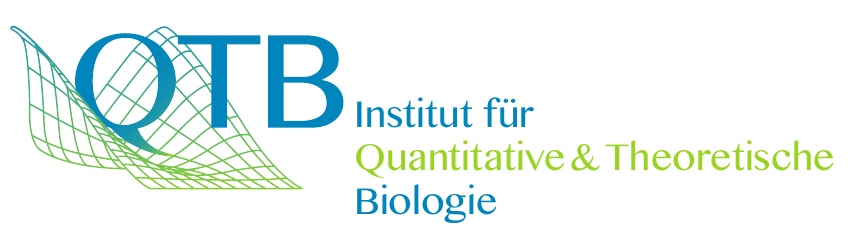

[1] Ebenhöh O., Fucile G., Finazzi G. G., Rochaix J.-D., and Goldschmidt-Clermont, M., (2014) Phil. Trans. R. Soc. Lon. B

## Install requirements
- NumPy
- matplotlib
- modelbase

In [1]:
# Import built-in libraries
import modelbase
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

MODELbase incorporates an easy construction method to define 'reactions'. Every model is defined by:
- model variables,
- model parameters,
- rate equations,
- stoichiometries.

With this information the system of differential equations is assembled **automatically**. You can either import and instantiate each component seperately

In [2]:
# Instantiate 3 modelling objects
import model
import parameters
import reactionrates

p = parameters.Parameters()
r = reactionrates.Reactions()
m = model.PETC2014(p, r)
s = modelbase.Simulator(m)

or call function instantitate, that will return all objects for you

In [3]:
import instantiate
p, rat, m, s = instantiate.instantiate()

Created a virtual organism. Experiment ready to run


## Model description
Model includes two compartments: lumenal and stromal side of the thylakoid membrance.

Units are expressed in $mmol/(mol Chl)s^{-1}$.

Default parameters are set to simulate PAM experiment with a dark to light transition and saturating pulse of light applied every 120 seconds. You can find the parameters in the ```p``` object

In [4]:
print('light on: ', p.Ton, '\nlight off: ', p.Toff, '\ntime between pulses: ', p.dT)

light on:  360 
light off:  1800 
time between pulses:  120


## Time course
To simulate simple experiment with a continuous light we can reset the default parameters using ```update``` method. Just set the continuous to True.

In [5]:
s.results.clear()
s.model.par.update({'continuous': True})

In [6]:
# Pass initial values
init = {"PQ":m.par.PQtot,
        "PC":0.0202,
        "Fd":5.000,
        "ATP":0.0,
        "NADPH":0.0,
        "H (lumen)":rat.pHinv(7.2),
        "LHC":0.9,
        'Fluo':0,
        'Light':p.PFD}

y0 = np.array(list(init.values()))

In [7]:
# Check the rates for the initial experimental conditions
m.rates(y0, t=0)

{'vPS2': -0.0,
 'vB6f': -5.751045728288371e-12,
 'vCyc': 0.0,
 'vPTOX': 0.0,
 'vNDH': 0.035,
 'vPS1': 0.0,
 'vFNR': 0.0,
 'vATPsynthase': 1200.0,
 'vATPconsumption': 0.0,
 'vNADPHconsumption': 0.0,
 'vLeak': 1.889872100936326e-06,
 'vSt12': 0.00012115384615384618,
 'vSt21': 0.00012999999999999996,
 'fluorescence': 0.020224719101123598,
 'light': 0.0}

In [8]:
# Define experimental conditions:
# T: time and PFD: light intensity
s.model.par.PFD = 200
T = np.linspace(0, 1000, 5000)

In [9]:
# Run the simulation 
s.timeCourse(T, y0);

## Display the results graphically

In [10]:
def plot(t,y,init,groups):
    """
    Input:
        t: time array
        y: value array
        init: dictionary with initvalues
        groups: nested list with groups for each plot
    """
    legend = list(init.keys())
    nrows = int(np.ceil((len(groups))/2))
    fig, ax = plt.subplots(nrows,2, figsize=[12,3*nrows])
    ax = ax.ravel()
    for plot,g in enumerate(groups):
        for i in g:
            ax[plot].plot(t,y[:,legend.index(i)],label=i)
            ax[plot].set_xlabel('time [s]')
        if plot % 2 == 0:
            ax[plot].legend(bbox_to_anchor=[-0.15, 1], loc='upper right',borderaxespad = 0)
        else:
            ax[plot].legend(bbox_to_anchor=[1.15, 1], loc='upper left',borderaxespad = 0)
            ax[plot].yaxis.tick_right()
        ax[plot].legend().set_visible(True)
    plt.tight_layout()
    plt.show()

In [15]:
# Group the variables to display them in a visually accesible way
groups = [
    ["ATP", "NADPH"],
    ["LHC"],
    ["PQ", "PC", "Fd"],
    ["H (lumen)"]]

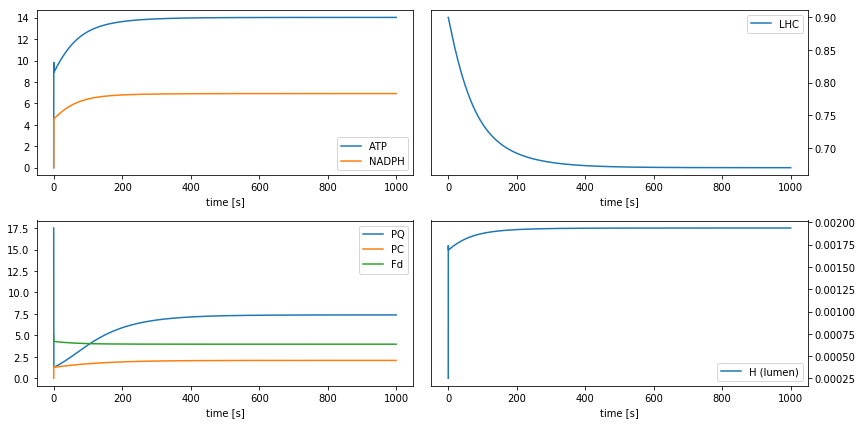

<Figure size 432x288 with 0 Axes>

In [16]:
# Display the results graphically
plot(T, s.getY(), init, groups)
plt.suptitle('Simulations for light intensity: '+str(s.model.par.PFD))
plt.show()

## Spectrum of possible analyses
#### 1. Plot the ratio between ATP and NADPH concentration over the time

/home/anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0,0.5,'ATP:NADPH')

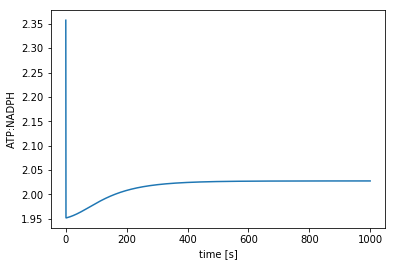

In [17]:
plt.plot(T, s.getVarByName('ATP')/s.getVarByName('NADPH') )
plt.xlabel('time [s]')
plt.ylabel('ATP:NADPH')

#### 2. How would this ratio change when the light intensity increases?

/home/anna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0,0.5,'ATP:NADPH')

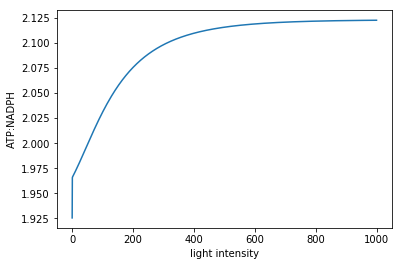

In [18]:
sh = modelbase.Simulator(m)
sh.model.par.PFD = 500
T = np.linspace(0, 1000, 5000)
sh.timeCourse(T, y0);
plt.plot(T, sh.getVarByName('ATP')/sh.getVarByName('NADPH') )
plt.xlabel('light intensity')
plt.ylabel('ATP:NADPH')

## Anoxia experiment
Observe the state transitions induced by anoxic conditions.

In [21]:
def anoxia(s, y0, Tmax=3600, Tflash=0.8):
    """Returns the solution of time integration with anoxia induced state transitions
    Anoxia is simulated by shutting down import reaction ssuch as PTOX and 
    setting the atmospheric oxygen to 0.
    
    Keyword arguments:
        Tmax -- time of experiment [in seconds]
        Ton -- time when the oxygen is taken [s]
        Toff -- time when the oxygen is put back into the system [s]
    """
    t = 0
    y = y0

    s.model.par.update({'continuous':False, 'PFD': 0, 'ox':False})
    try:
        '''only executed if assimulo is used'''
        s.integrator.atol = 1.e-8
    except:
        pass

    # =========================================== #
    # Anoxia experiment simulation in three parts #
    while s.successful() and t < Tmax:    
        if t%s.model.par.dT == 0:
            tfl = np.linspace(t, t+Tflash, 100)
            s.timeCourse(tfl, y)

        else:
            #switch on the light except for the dark period
            #t+dT-Tflash is the time to the next flash
            if t<= s.model.par.Ton or t>=s.model.par.Toff:
                tIfl = np.linspace(t, t+s.model.par.dT-Tflash, 10000)
                s.timeCourse(tIfl, y)
            else:
                #put the actinic light
                tIfl = np.linspace(t, t+s.model.par.dT-Tflash, 1000)
                s.timeCourse(tIfl, y)
        t = s.getT()[-1]
        y = s.getVarsByName(s.model.cpdNames)[-1]
    
    return s, s.model

In [22]:
p, rat, m, s = instantiate.instantiate()

# Pass initial values
init = {"PQ":m.par.PQtot,
        "PC":0.0202,
        "Fd":5.000,
        "ATP":0.0,
        "NADPH":0.0,
        "H (lumen)":rat.pHinv(7.2),
        "LHC":0.9,
        'Fluo':0,
        'Light':p.PFD}

y0 = np.array(list(init.values()))   

s, m = anoxia(s, y0)

Created a virtual organism. Experiment ready to run


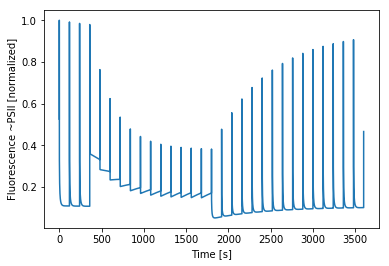

In [23]:
# Plot the results
plt.figure()
fl = s.getRate('fluorescence')
plt.plot(s.getT(), fl/max(fl))
plt.xlabel('Time [s]')
plt.ylabel('Fluorescence ~PSII [normalized]')

plt.show()